# Pre-trained embeddings headline sentiment analysis
This notebook performs sentiment analysis on article headlines with pre-trained embeddings to evaluate relationship between author gender and polarity score.

In [ ]:
!pip install gender_guesser
!pip install -q transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gender_guesser.detector as gender
plt.style.use('ggplot')
%matplotlib inline

import statsmodels.api as sm
from scipy import stats

import nltk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/[4] Final Paper 2023, BSc/[11] Author gender and sentiment analysis/sa_emotion.csv')

In [ ]:
df["first_names"] = df["author"].str.split(",")

In [ ]:
df = df.dropna(subset=['first_names'])
for index, row in df.iterrows():
    if len(row['first_names']) > 1:
        print(row['first_names'])

## Gender Prediction

In [ ]:
import gender_guesser.detector as gender
d = gender.Detector()

df['genders'] = [[d.get_gender(name.split()[0]) for name in authors] for authors in df['first_names']]


In [ ]:
for index, row in df.iterrows():
    if len(row['genders']) > 1:
        print(row['genders'])

In [ ]:
from collections import Counter

def get_majority_gender(genders):
    gender_count = Counter(genders)
    return gender_count.most_common(1)[0][0]

df["majority_gender"] = df["genders"].apply(get_majority_gender)


In [ ]:
df['majority_gender']

0         female
1        unknown
2           male
3           male
4         female
          ...   
40121    unknown
40122    unknown
40123    unknown
40124       male
40125       male
Name: majority_gender, Length: 40124, dtype: object

In [ ]:
df.groupby('majority_gender').count()['Id']

majority_gender
andy               182
female            9783
male             24823
mostly_female      936
mostly_male       1687
unknown           2713
Name: Id, dtype: int64

In [ ]:
df.groupby(['section', 'majority_gender']).count()['Id']

section          majority_gender
Arts             andy                   8
                 female              5131
                 male               11898
                 mostly_female        418
                 mostly_male          643
                 unknown              933
Books            andy                  31
                 female              2524
                 male                2250
                 mostly_female        204
                 mostly_male           92
                 unknown              381
Education        female               101
                 male                  45
                 mostly_female         37
                 mostly_male            1
                 unknown               20
Fashion & Style  andy                   2
                 female               704
                 male                 658
                 mostly_female        123
                 mostly_male            8
                 unknown              154
F

In [ ]:
df.to_csv('/content/drive/MyDrive/[4] Final Paper 2023, BSc/[11] Author gender and sentiment analysis/majority_gender.csv')

## Sentiment Analysis


In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm import tqdm

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
example = df['headline'][120]

In [ ]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.06354878, 'roberta_neu': 0.8119842, 'roberta_pos': 0.12446704}


In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    
    return scores_dict

### Headline polarity

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['headline']
        myid = df.index[i]
      
        roberta_result = polarity_scores_roberta(text)
        
        res[i] = roberta_result
    except RuntimeError:
        print(f'Broke for id {myid}')

In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})

In [ ]:
results_df

In [ ]:
df = df.reset_index().rename(columns={'index': 'Id'})

In [ ]:
merged = pd.merge(df, results_df, on='Id')

In [ ]:
merged.head()

### Headline emotions


In [ ]:
emotion ='bhadresh-savani/distilbert-base-uncased-emotion'
tokenizer_emotion = AutoTokenizer.from_pretrained(emotion)
emo = AutoModelForSequenceClassification.from_pretrained(emotion)

In [ ]:
encoded_text = tokenizer_emotion(example, return_tensors='pt')
output = emo(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'sadness': scores[0], 
    'joy': scores[1], 
    'love':  scores[2],
    'anger': scores[3], 
    'fear': scores[4], 
    'surprise': scores[5]
}
print(scores_dict)

In [ ]:
def emotion_scores_bert(example):
    encoded_text = tokenizer_emotion(example, return_tensors='pt')
    output = emo(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
    'sadness': scores[0], 
    'joy': scores[1], 
    'love':  scores[2],
    'anger': scores[3], 
    'fear': scores[4], 
    'surprise': scores[5]
    }
    
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['headline']
        myid = df.index[i]
      
        bert_result = emotion_scores_bert(text)
        
        res[i] = bert_result
    except RuntimeError:
        print(f'Broke for id {myid}')

In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})

In [ ]:
merged = pd.merge(df, results_df, on='Id')

In [ ]:
merged.head()

In [ ]:
merged['year']

## Evaluation


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/[4] Final Paper 2023, BSc/[11] Author gender and sentiment analysis/majority_gender.csv')

In [ ]:
df = df.drop(df[df['majority_gender'] == 'unknown'].index)

In [ ]:
df['gender_new_multi'] = df['majority_gender'].replace({'male': 'Male', 'mostly_male': 'Male', 'female': 'Female', 'mostly_female': 'Female', 'andy': 'Androgenous'})

In [ ]:
df.head()

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Id,Unnamed: 0,headline,date,web_url,doc_type,lead_paragraph,...,sadness,joy,love,anger,fear,surprise,first_names,genders,majority_gender,gender_new_multi
0,0,0,0,0,0,How Much Watching Time Do You Have This Weekend?,2019-03-01,https://www.nytimes.com/2019/02/28/arts/televi...,article,No matter how much free time you have this wee...,...,0.036533,0.317630,0.005219,0.550749,0.085238,0.004631,[' Margaret Lyons'],['female'],female,Female
2,2,2,2,2,2,What’s on TV Friday: ‘The Boy Who Harnessed th...,2019-03-01,https://www.nytimes.com/2019/03/01/arts/televi...,article,Chiwetel Ejiofor’s directorial debut hits Netf...,...,0.074762,0.129860,0.014392,0.628263,0.144119,0.008603,[' Gabe Cohn'],['male'],male,Male
3,3,3,3,3,3,New York Has a Public Housing Problem. Does Lo...,2019-03-01,https://www.nytimes.com/2019/03/01/arts/design...,article,LONDON — Is there a better way to do public ho...,...,0.014387,0.010716,0.000827,0.927617,0.045445,0.001009,[' Michael Kimmelman'],['male'],male,Male
4,4,4,4,4,4,William Forsythe: ‘Isn’t Ballet Delightful?’,2019-03-01,https://www.nytimes.com/2019/03/01/arts/dance/...,article,BOSTON — “Give me a little booty! Show off! Gl...,...,0.000840,0.995359,0.001461,0.000564,0.000471,0.001305,[' Roslyn Sulcas'],['female'],female,Female
5,5,5,5,5,5,Jimmy Kimmel Compares Trump’s Failed North Kor...,2019-03-01,https://www.nytimes.com/2019/03/01/arts/televi...,article,"Welcome to Best of Late Night, a rundown of th...",...,0.298083,0.040747,0.004838,0.635786,0.016495,0.004050,[' Giovanni Russonello'],['male'],male,Male


### Visual analysis

In [ ]:
df.groupby('majority_gender').sum()['roberta_neu']

<ipython-input-13-fe342818ad15>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('majority_gender').sum()['roberta_neu']


majority_gender
andy               126.974948
female            7088.203991
male             17629.254817
mostly_female      674.072683
mostly_male       1205.322599
Name: roberta_neu, dtype: float64

In [ ]:
top_10 = df.sort_values('roberta_neg', ascending=False)[['headline', 'gender_new_multi', 'roberta_neg', 'section']].iloc[:10]
latex = top_10.to_latex(index=False, float_format="%.3f")
print(latex)

\begin{tabular}{llrl}
\toprule
                                          headline & gender\_new\_multi &  roberta\_neg &   section \\
\midrule
The Yankees and Their Terrible, Horrible, No-Go... &             Male &        0.964 &    Sports \\
                     Why Are Americans So Anxious? &           Female &        0.960 &     Books \\
                          Why Is My Baby So Hairy? &           Female &        0.957 & Parenting \\
             The Aperol Spritz Is Not a Good Drink &           Female &        0.954 &      Food \\
              Just How Bad Are the Miami Dolphins? &             Male &        0.950 &    Sports \\
Why Do People Who Need Help From the Government... &             Male &        0.948 &     Books \\
                  How Racism Is Destroying America &             Male &        0.945 &     Books \\
               Why the Greek Bailout Went So Wrong &             Male &        0.944 &     Books \\
When the Aftermath of a Shooting Is as Devastat... &     

<ipython-input-44-90780fad28ee>:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = top_10.to_latex(index=False, float_format="%.3f")


In [ ]:
top_10 = df.sort_values('roberta_neu', ascending=False)[['headline', 'gender_new_multi', 'roberta_neu', 'section']].iloc[:10]
latex = top_10.to_latex(index=False, float_format="%.3f")
print(latex)

\begin{tabular}{llrl}
\toprule
                                          headline & gender\_new\_multi &  roberta\_neu & section \\
\midrule
Yankees Acquire Todd Frazier and David Robertso... &      Androgenous &        0.962 &  Sports \\
Coco Gauff Will Play in the U.S. Open as a Wild... &             Male &        0.962 &  Sports \\
Allie Kiick, No. 633, Qualifies for Main Draw o... &           Female &        0.962 &  Sports \\
British Open Leaderboard: Jordan Spieth Pulls A... &           Female &        0.959 &  Sports \\
Tiger Woods Cards a 76 at Torrey Pines in Tour ... &           Female &        0.959 &  Sports \\
Mets Select Two Pitchers From Long Island in Am... &      Androgenous &        0.959 &  Sports \\
The Menil Drawing Institute in Houston Will Ope... &             Male &        0.958 &    Arts \\
  Yankees Pick C.C. Sabathia for 5th Rotation Slot &             Male &        0.958 &  Sports \\
Mets Announce Dominic Smith Will Make His Debut... &             Male &    

<ipython-input-45-b4a3c038b0dd>:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = top_10.to_latex(index=False, float_format="%.3f")


In [ ]:
top_10 = df.sort_values('roberta_pos', ascending=False)[['headline', 'gender_new_multi', 'roberta_pos', 'section']].iloc[:10]
latex = top_10.to_latex(index=False, float_format="%.3f")
print(latex)

\begin{tabular}{llrl}
\toprule
                                          headline & gender\_new\_multi &  roberta\_pos &   section \\
\midrule
Comfort Viewing: 3 Reasons I Love ‘Tim and Eric... &             Male &        0.985 &      Arts \\
   My C-Section Was the Happiest Moment of My Life &           Female &        0.985 & Parenting \\
The Islanders’ Travis Hamonic Is as Excited as ... &             Male &        0.982 &    Sports \\
This A.C.C. Might Be the Best Basketball League... &             Male &        0.981 &    Sports \\
              Happy 20th Anniversary, Harry Potter &           Female &        0.977 &     Books \\
Late Night Wishes President Trump a Happy Birthday &             Male &        0.976 &      Arts \\
Twitter Loves the Opera Diva Karita Mattila. An... &             Male &        0.976 &      Arts \\
Nashville Celebrates Its Heroes and Welcomes Be... &             Male &        0.976 &      Arts \\
The New Season of ‘GLOW’ Is Even Better Than th... &     

<ipython-input-46-4fca7ed48fc9>:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = top_10.to_latex(index=False, float_format="%.3f")


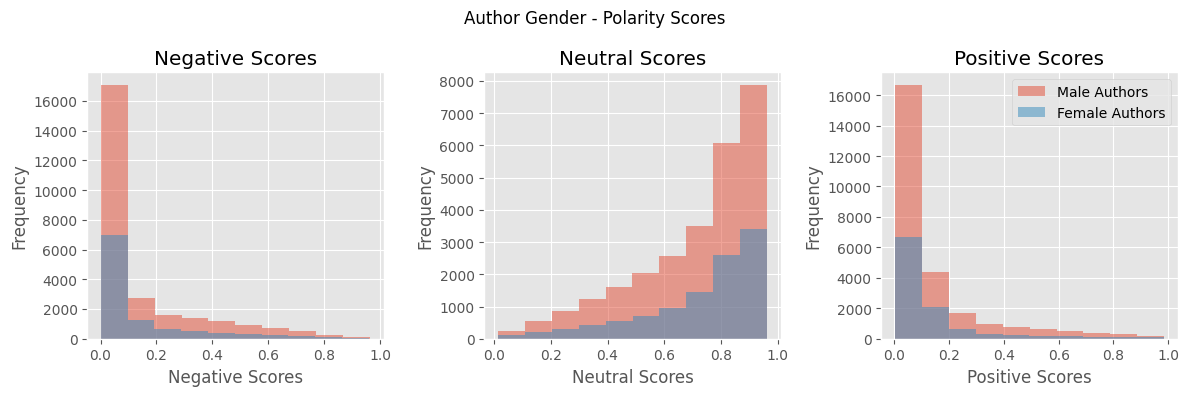

In [ ]:

male_authors = df[df['gender_new_multi'] == 'Male']
female_authors = df[df['gender_new_multi'] == 'Female']

fig, axs = plt.subplots(ncols=3, figsize=(12, 4))


axs[0].hist(male_authors['roberta_neg'], alpha=0.5, label='Male Authors')
axs[0].hist(female_authors['roberta_neg'], alpha=0.5, label='Female Authors')
axs[0].set_xlabel('Negative Scores')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Negative Scores')

axs[1].hist(male_authors['roberta_neu'], alpha=0.5, label='Male Authors')
axs[1].hist(female_authors['roberta_neu'], alpha=0.5, label='Female Authors')
axs[1].set_xlabel('Neutral Scores')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Neutral Scores')

axs[2].hist(male_authors['roberta_pos'], alpha=0.5, label='Male Authors')
axs[2].hist(female_authors['roberta_pos'], alpha=0.5, label='Female Authors')
axs[2].set_xlabel('Positive Scores')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Positive Scores')

plt.suptitle('Author Gender - Polarity Scores')
plt.legend()
plt.tight_layout()
plt.savefig('new.png', dpi=300)
plt.show()

### Statistical and econometric analysis


In [ ]:
grouped = df.groupby('gender_new_multi')
stats_df = grouped[['roberta_neg', 'roberta_neu', 'roberta_pos']].agg(['mean', 'median', 'var', 'std'])

print(stats_df)

                 roberta_neg                               roberta_neu  \
                        mean    median       var       std        mean   
gender_new_multi                                                         
Androgenous         0.125850  0.030168  0.034136  0.184759    0.697665   
Female              0.137491  0.043319  0.037785  0.194383    0.724161   
Male                0.143211  0.042559  0.039734  0.199335    0.710471   

                                               roberta_pos            \
                    median       var       std        mean    median   
gender_new_multi                                                       
Androgenous       0.740316  0.039421  0.198548    0.176486  0.078566   
Female            0.805719  0.042973  0.207299    0.138349  0.073997   
Male              0.787599  0.045169  0.212530    0.146318  0.071299   

                                      
                       var       std  
gender_new_multi                      
Andro

In [ ]:
for col in ['roberta_neg', 'roberta_neu', 'roberta_pos']:
    male_scores = df[df['gender_new_multi'] == 'Male'][col]
    female_scores = df[df['gender_new_multi'] == 'Female'][col]
    t_stat, p_value = stats.ttest_ind(male_scores, female_scores, equal_var=False)
    print(f"{col} t-statistic: {t_stat:.3f}, p-value: {p_value:.3f}")

In [ ]:
y = df['roberta_neg']
X = df[['gender_new_multi', 'section', 'year']]

X = pd.get_dummies(X, columns=['section', 'gender_new_multi'])

X = X.drop(columns=['gender_new_multi_Androgenous'])

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            roberta_neg   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     77.71
Date:                Thu, 27 Apr 2023   Prob (F-statistic):          1.64e-189
Time:                        01:00:12   Log-Likelihood:                 7987.6
No. Observations:               37411   AIC:                        -1.595e+04
Df Residuals:                   37398   BIC:                        -1.584e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

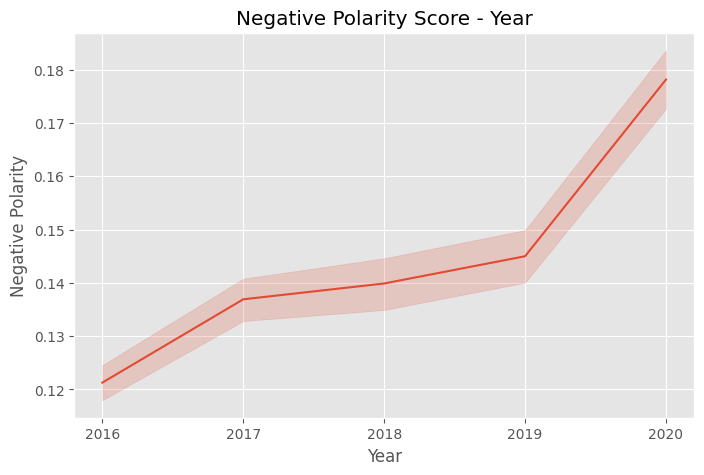

In [ ]:
df['year'] = df['year'].astype(int)

plt.figure(figsize=(8,5))
sns.lineplot(x='year', y='roberta_neg', data=df)

plt.xticks(df['year'].unique())
plt.xlabel('Year')
plt.ylabel('Negative Polarity')
plt.title('Negative Polarity Score - Year')
plt.savefig('neg-year.png', dpi=300)
plt.show()
